### Import das libs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tensorflow.keras.optimizers import Adam
import numpy as np

### Data Loading

In [2]:
symbol = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-07-01'

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Open', 'Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close
Ticker,TSLA,TSLA
Date,,
2015-01-02 00:00:00+00:00,14.858000,14.620667
2015-01-05 00:00:00+00:00,14.303333,14.006000
2015-01-06 00:00:00+00:00,14.004000,14.085333
2015-01-07 00:00:00+00:00,14.223333,14.063333
2015-01-08 00:00:00+00:00,14.187333,14.041333


### EDA

In [4]:
df.shape

(2388, 2)

In [9]:
df.columns

MultiIndex([( 'Open', 'TSLA'),
            ('Close', 'TSLA')],
           names=['Price', 'Ticker'])

In [6]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
Price                           Open      Close
Ticker                          TSLA       TSLA
Date                                           
2015-01-02 00:00:00+00:00  14.858000  14.620667
2015-01-05 00:00:00+00:00  14.303333  14.006000
2015-01-06 00:00:00+00:00  14.004000  14.085333
2015-01-07 00:00:00+00:00  14.223333  14.063333
2015-01-08 00:00:00+00:00  14.187333  14.041333


In [7]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
Price          Open        Close
Ticker         TSLA         TSLA
count   2388.000000  2388.000000
mean     107.177681   107.145222
std      109.733298   109.631348
min        9.488000     9.578000
25%       16.863000    16.904167
50%       23.829333    23.807667
75%      209.467499   209.284168
max      411.470001   409.970001


### Análises exploratórias

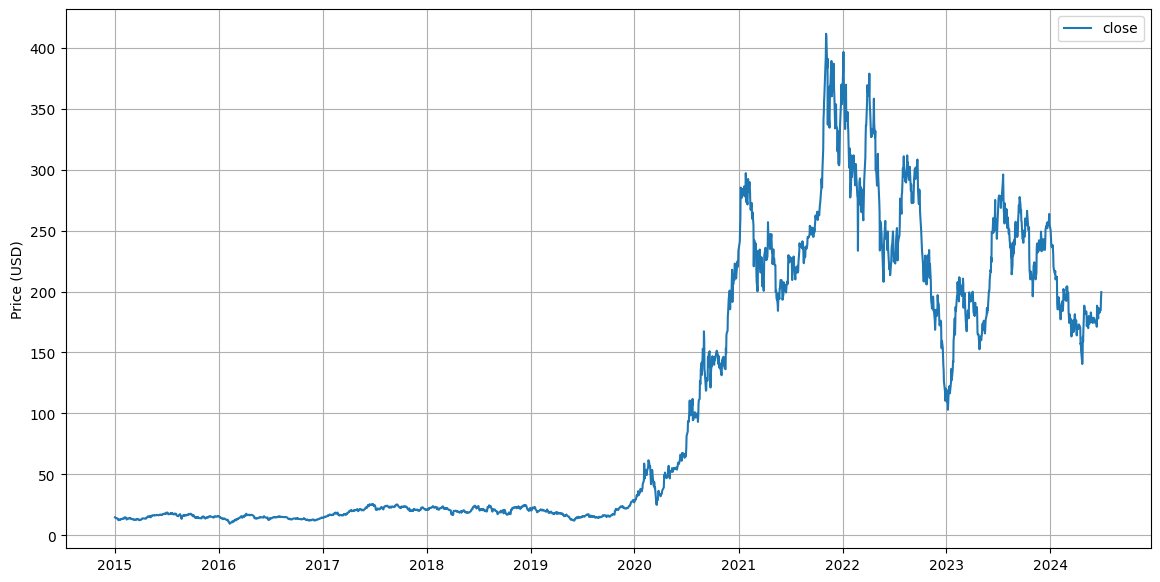

In [14]:
# Plotting the closing price
plt.figure(figsize=(14, 7))
plt.plot(df['Open'], label='close')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

A partir desse gráfico, podemos observar:

Tendência de alta: A linha azul mostra uma tendência geral de crescimento do preço das ações da Tesla ao longo dos anos, indicando um aumento significativo no valor da empresa.

Volatilidade: O preço das ações não segue uma linha reta, apresentando diversas oscilações para cima e para baixo. Isso é comum no mercado de ações e reflete a volatilidade inerente aos investimentos.

Períodos de alta e baixa: É possível identificar períodos de maior crescimento e outros de menor crescimento ou até mesmo de queda no preço das ações, o que pode estar relacionado a diversos fatores, como notícias sobre a empresa, condições do mercado em geral e outros eventos.

In [15]:
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
Price  Ticker
Open   TSLA      0
Close  TSLA      0
dtype: int64


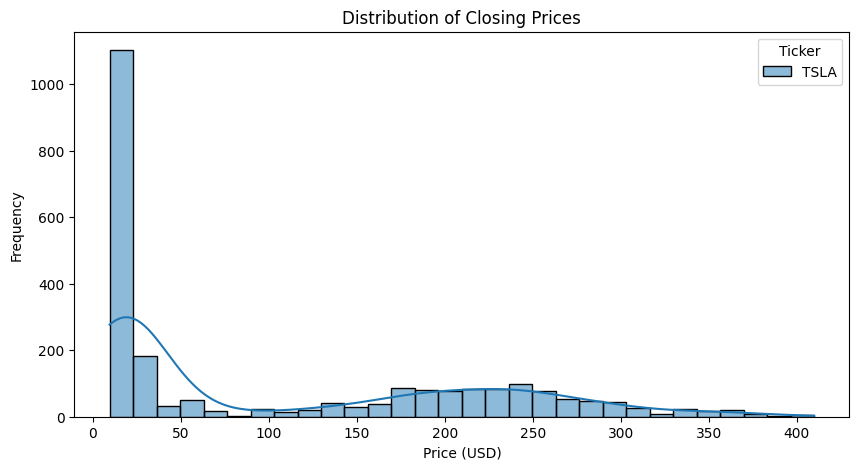

In [17]:
# Plot the distribution of the closing prices
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], kde=True, bins=30)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

Este gráfico representa a distribuição dos preços de fechamento (Closing Prices) de uma ação (no caso, o ticker TSLA - Tesla), com base no histórico de dados.

Histórico de preços mais baixos:

O gráfico sugere que, no período analisado, o preço das ações da Tesla esteve majoritariamente em um nível mais baixo.
Possível impacto de crescimento:

A cauda longa pode refletir aumentos recentes ou eventos que levaram a uma valorização das ações, mas esses valores altos foram menos frequentes.
Importância de normalização:

Antes de usar esses dados em modelos de machine learning, pode ser necessário normalizá-los, especialmente devido à assimetria.

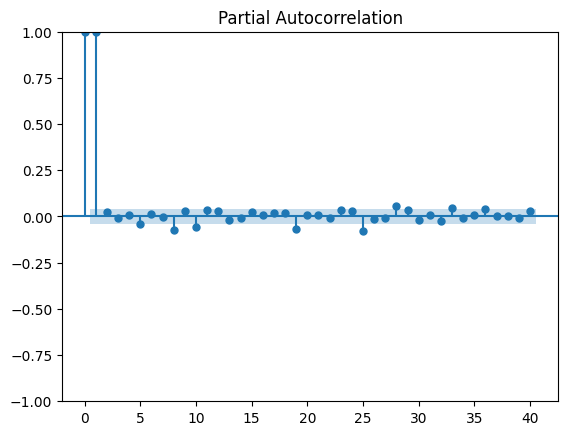

In [19]:
plot_pacf(df['Close'].dropna(), lags=40, method='ywm')
plt.show()

O que o gráfico indica?

Os dois primeiros lags possuem uma autocorrelação parcial significativa (barras altas acima do intervalo de confiança).
Isso sugere que há uma relação direta forte entre o valor atual da série e os dois atrasos mais próximos.

Padrão estacionário ou próximo disso:

A presença de apenas alguns lags significativos no PACF é uma característica comum de séries estacionárias (ou transformadas para estacionariedade).

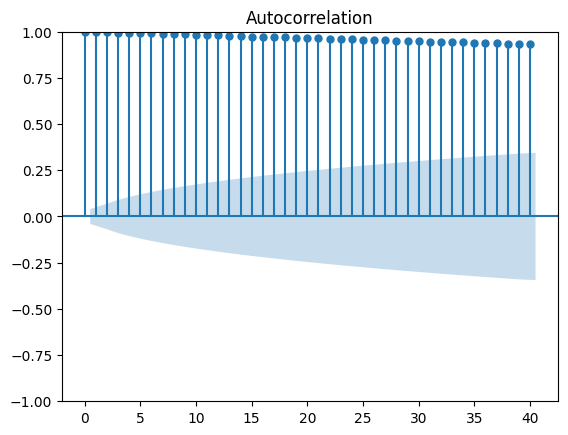

In [21]:
plot_acf(df['Close'].dropna(), lags=40)
plt.show()

Esse é um gráfico de Autocorrelação (ACF - AutoCorrelation Function), que mostra o quanto uma série temporal está correlacionada consigo mesma em diferentes atrasos (lags).


O que o gráfico indica? Alta autocorrelação.


Neste gráfico, todas as barras estão acima do intervalo de confiança, indicando que há uma alta dependência temporal na série, ou seja, os valores passados têm forte influência nos valores futuros.

Padrão não-estacionário:
Um comportamento onde as barras caem lentamente (decrescimento lento da autocorrelação) sugere que a série não é estacionária, o que significa que a média ou a variância pode mudar ao longo do tempo.

### Pré processamento

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Função para criar janelas temporais
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1886, 30, 1)
(1886,)
(472, 30, 1)
(472,)


### Criação e treinamento do modelo

In [23]:
# Estrutura do modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0276 - val_loss: 0.0016
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

### Resultados

In [24]:
# Avaliação
model.evaluate(X_test, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1266e-04


0.0006802165880799294

In [25]:
# Predições
y_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [26]:
y_test_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(root_mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 5.66
Root Mean Squared Error (RMSE): 3.23


In [27]:
mse = root_mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')

MSE: 0.026080962086568973
RMSE: 0.16149601260269236
MAPE: 31386403371.50772


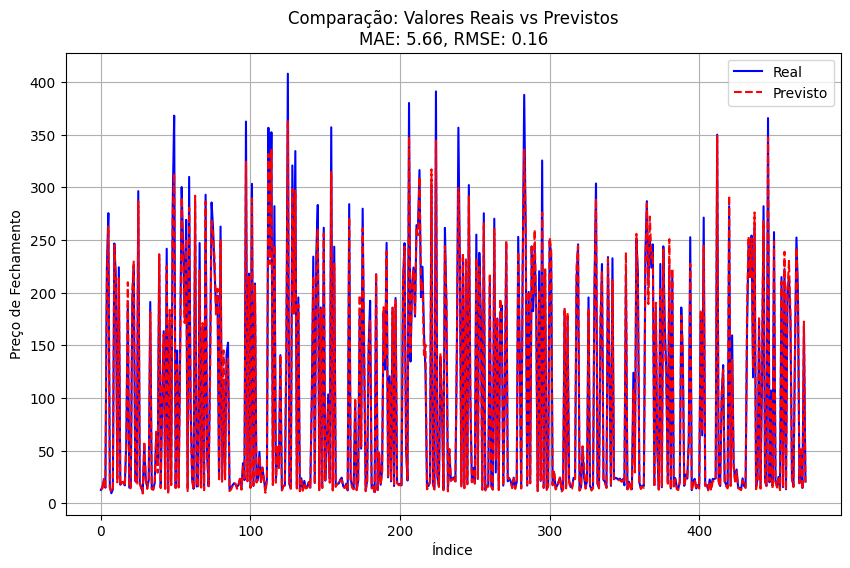

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Real", color='blue')
plt.plot(y_pred_rescaled, label="Previsto", color='red', linestyle='dashed')
plt.title(f'Comparação: Valores Reais vs Previstos\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### Otimização de hiper parâmetros com Hyperopt ❤

In [49]:
# Extraindo os dados de 'Open' e 'Close' para o Ticker TSLA
df_tsla = df[('Open', 'TSLA')].to_frame().join(df[('Close', 'TSLA')])

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_tsla)

# Função para criar os dados de entrada (X) e alvo (y) para o modelo LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])  # Usando a 'Open' para previsões
        y.append(data[i + time_step, 1])  # 'Close' como target
    return np.array(X), np.array(y)

# Ajuste do parâmetro time_step
time_step = 60  # Número de dias anteriores para prever o preço de fechamento
X, y = create_dataset(scaled_data, time_step)

# Redimensionando para [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # [samples, time_steps, features]

# Definir o espaço de busca para o Hyperopt
space = {
    'units': hp.choice('units', [50, 100, 150]),  # Número de neurônios na LSTM
    'dropout': hp.uniform('dropout', 0.2, 0.5),  # Taxa de dropout
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Taxa de aprendizado
    'batch_size': hp.choice('batch_size', [16, 32, 64]),  # Tamanho do batch
    'epochs': hp.choice('epochs', [50, 100])  # Número de épocas
}

# Definir a função objetivo
def objective(params):
    # Criar o modelo com os hiperparâmetros fornecidos
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Definir explicitamente a forma da entrada
        LSTM(int(params['units']), return_sequences=True),
        Dropout(params['dropout']),
        LSTM(int(params['units']), return_sequences=False),
        Dropout(params['dropout']),
        Dense(1)  # Prevendo o 'Close'
    ])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')

    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Treinamento do modelo
    history = model.fit(
        X, y,
        validation_split=0.2,
        batch_size=int(params['batch_size']),
        epochs=int(params['epochs']),
        callbacks=[early_stopping],
        verbose=0  # Silenciar os logs do treinamento
    )

    # Avaliar o menor val_loss
    val_loss = min(history.history['val_loss'])
    return {'loss': val_loss, 'status': STATUS_OK}

# Criar um Trials para rastrear os resultados
trials = Trials()

# Executar a otimização
best = fmin(
    fn=objective,  # Função objetivo
    space=space,  # Espaço de busca
    algo=tpe.suggest,  # Método de otimização
    max_evals=10,  # Número de tentativas
    trials=trials  # Armazenar os resultados
)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros:", best)


100%|██████████| 10/10 [26:28<00:00, 158.81s/trial, best loss: 0.0006235065520741045]
Melhores hiperparâmetros: {'batch_size': 1, 'dropout': 0.33703013391751124, 'epochs': 1, 'learning_rate': 0.006098030985039481, 'units': 1}


Por que o Hyperopt?

O Hyperopt é uma ótima escolha como otimizador de parâmetros porque ele utiliza métodos de busca eficientes, como a otimização bayesiana, que podem explorar o espaço de parâmetros de maneira inteligente e eficaz. Isso resulta em uma busca mais rápida e precisa, comparado a métodos tradicionais como grid search e random search. Além disso, o Hyperopt é capaz de otimizar parâmetros contínuos e discretos, e pode ser facilmente integrado a pipelines de machine learning, oferecendo flexibilidade e performance.